# Análisis para la app de la empresa alimenticia

**Propósito del proyecto:**

El propósito del proyecto es evaluar mediante una prueba A/A/B si la modificación en las fuentes tipográficas de la aplicación de la empresa genera algún impacto significativo en el comportamiento de los usuarios.

## Inicialización

In [ ]:
import pandas as pd
import numpy as np
import math as mth
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

## Cargar datos

In [ ]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


## Procesar datos

In [ ]:
# Cambiar nombre de columnas
data.columns = ['event_name', 'user_id', 'event_datetime', 'exp_id']

In [ ]:
# Cambiar tipo de datos
data['event_datetime'] = pd.to_datetime(data['event_datetime'], unit='s')

In [ ]:
# Agregar columna de fecha
data['event_date'] = data['event_datetime'].dt.date

In [ ]:
print(data.head(5))

                event_name              user_id      event_datetime  exp_id  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36     246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42     246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47     248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47     248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42     248   

   event_date  
0  2019-07-25  
1  2019-07-25  
2  2019-07-25  
3  2019-07-25  
4  2019-07-25  


## Estudio de los datos

### ¿Cuántos eventos hay en los registros?

In [ ]:
total_events = len(data)
print(f"Número total de eventos: {total_events}")

Número total de eventos: 244126


### ¿Cuántos usuarios hay en los registros?

In [ ]:
total_users = data['user_id'].nunique()
print(f"Número total de usuarios: {total_users}")

Número total de usuarios: 7551


### ¿Cuál es el promedio de eventos por usuario?

In [ ]:
avg_events_per_user = total_events / total_users
print(f"Promedio de eventos por usuario: {avg_events_per_user:.2f}")

Promedio de eventos por usuario: 32.33


### ¿Qué periodo de tiempo cubren los datos?

In [ ]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'])

fecha_min = data['event_datetime'].min()
fecha_max = data['event_datetime'].max()

print(f"Desde: {fecha_min}, Hasta: {fecha_max}")

Desde: 2019-07-25 04:43:36, Hasta: 2019-08-07 21:15:17


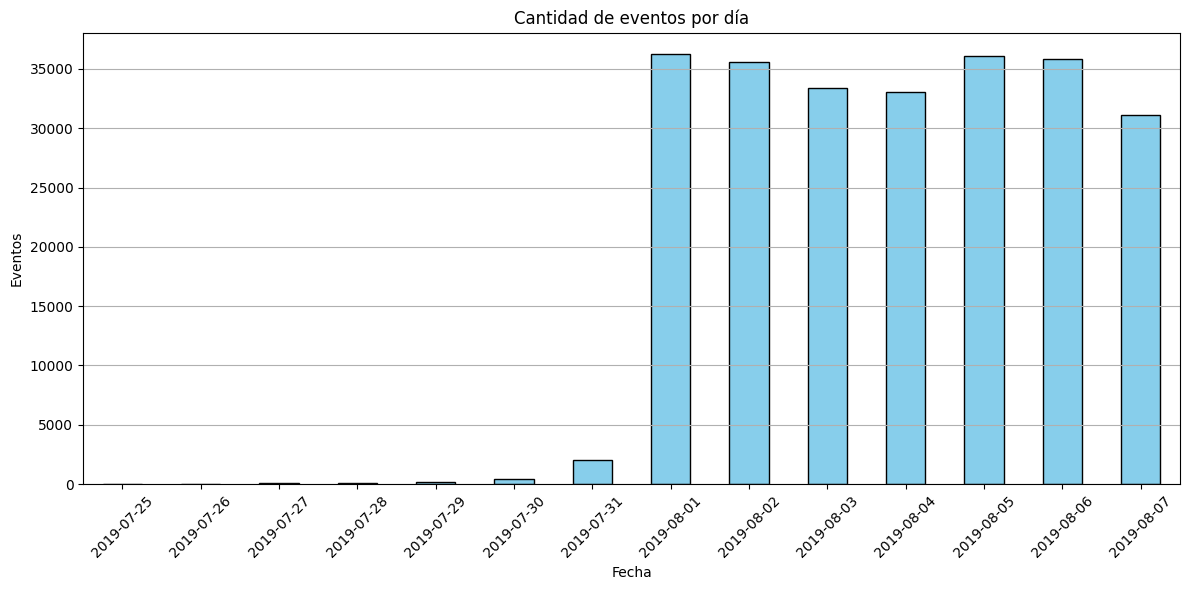

In [ ]:
plt.figure(figsize=(12, 6))
data['event_date'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Eventos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Limpiar datos incompletos al inicio
inicio_analisis = pd.to_datetime('2019-08-01')
data_limpia = data[data['event_date'] >= inicio_analisis]

eventos_filtrados = len(data_limpia)
usuarios_filtrados = data_limpia['user_id'].nunique()

print(f"Eventos conservados: {eventos_filtrados}")
print(f"Usuarios conservados: {usuarios_filtrados}")

Eventos conservados: 241298
Usuarios conservados: 7534


In [ ]:
# Verificar que estan los tres grupos experimentales
grupos = data_limpia['exp_id'].unique()
print(f"Grupos experimentales encontrados: {grupos}")

Grupos experimentales encontrados: [246 247 248]


**Conclusiones:**

Al excluir los datos más antiguos, se perdieron pocos eventos y usuarios, pero esta pérdida no necesariamente es negativa. De hecho, es una práctica esencial para garantizar la integridad del análisis. El histograma mostró una acumulación irregular de eventos en los primeros días, ya sea por registros parciales, errores de sincronización o simplemente bajo tráfico inicial, mantenerlos podría sesgar los resultados del test A/A/B.

La limpieza permite trabajar con un periodo estable y representativo, donde la distribución de usuarios y eventos refleja el comportamiento real. Entonces, aunque se haya reducido el volumen de datos, se gana en precisión, equilibrio y validez estadística. Y eso, para un test de este tipo, vale mucho más.

## Embudo de eventos

### Eventos por frecuencia total

In [ ]:
event_frequencies = data['event_name'].value_counts()
print(event_frequencies)

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64


### Usuarios únicos por tipo de evento

In [ ]:
users_by_event = data_limpia.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
print(users_by_event)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64


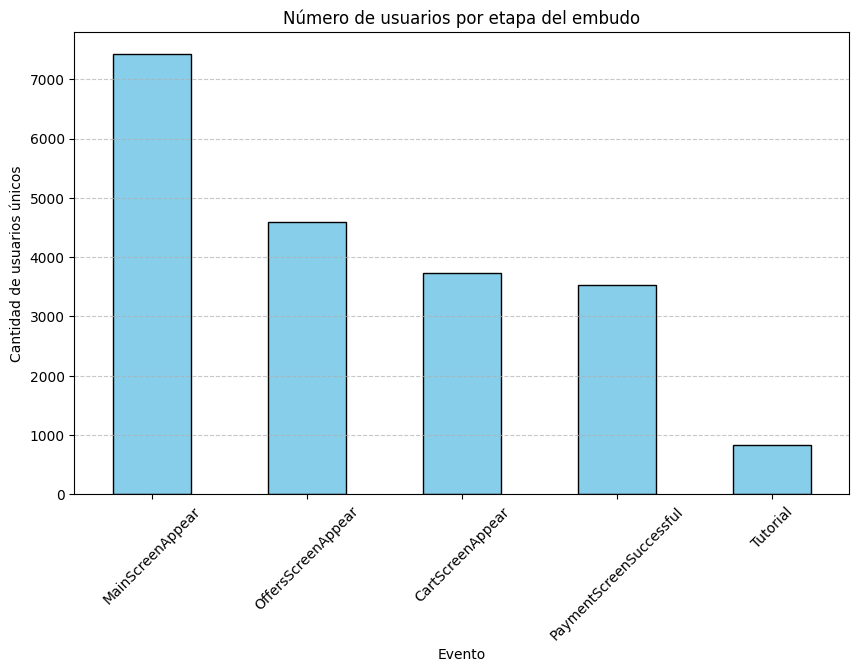

In [ ]:
plt.figure(figsize=(10, 6))
users_by_event.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Evento')
plt.ylabel('Cantidad de usuarios únicos')
plt.title('Número de usuarios por etapa del embudo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Proporción de usuarios que realizaron cada acción

In [ ]:
user_ratios = users_by_event / usuarios_filtrados * 100
print(user_ratios)

event_name
MainScreenAppear           98.473586
OffersScreenAppear         60.963632
CartScreenAppear           49.561986
PaymentScreenSuccessful    46.973719
Tutorial                   11.149456
Name: user_id, dtype: float64


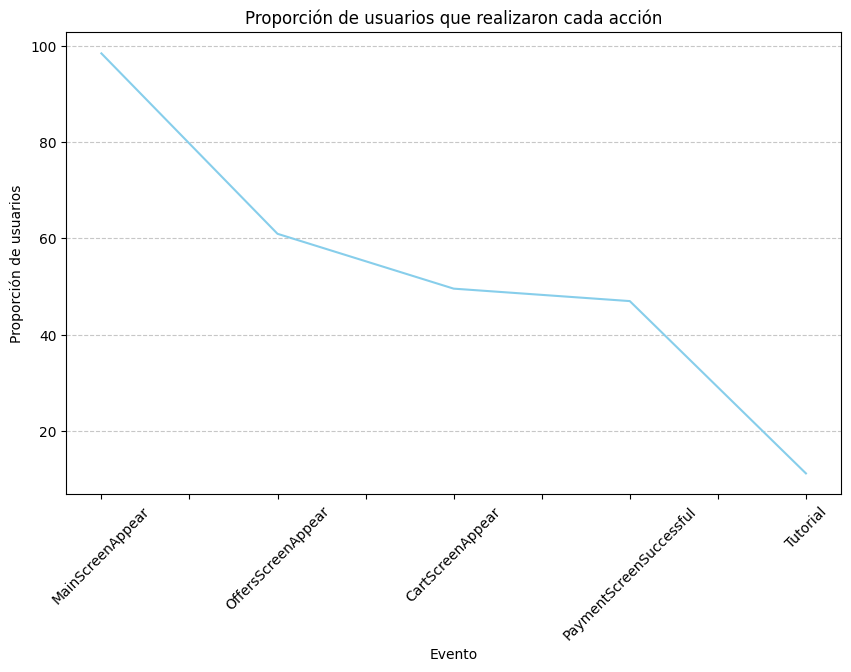

In [ ]:
plt.figure(figsize=(10, 6))
user_ratios.plot(kind='line', color='skyblue')

plt.xlabel('Evento')
plt.ylabel('Proporción de usuarios')
plt.title('Proporción de usuarios que realizaron cada acción')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Proporciones entre etapas

In [ ]:
ordered_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

users_per_stage = data_limpia[data_limpia['event_name'].isin(ordered_events)].groupby('event_name')['user_id'].nunique()

# Calcular proporciones entre etapas
conversion_from_main_to_offer = users_per_stage['OffersScreenAppear'] / users_per_stage['MainScreenAppear'] * 100
conversion_from_offer_to_cart = users_per_stage['CartScreenAppear'] / users_per_stage['OffersScreenAppear'] * 100
conversion_from_cart_to_payment = users_per_stage['PaymentScreenSuccessful'] / users_per_stage['CartScreenAppear'] * 100

print(f"Main → Offers: {conversion_from_main_to_offer:.2f}%")
print(f"Offers → Cart: {conversion_from_offer_to_cart:.2f}%")
print(f"Cart → Payment: {conversion_from_cart_to_payment:.2f}%")

Main → Offers: 61.91%
Offers → Cart: 81.30%
Cart → Payment: 94.78%


### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [ ]:
usuarios_main = set(data_limpia[data_limpia['event_name'] == 'MainScreenAppear']['user_id'])
usuarios_pago = set(data_limpia[data_limpia['event_name'] == 'PaymentScreenSuccessful']['user_id'])

porcentaje_completos = len(usuarios_pago.intersection(usuarios_main)) / len(usuarios_main) * 100
print(f"Usuarios que completaron todo el recorrido: {porcentaje_completos:.2f}%")

Usuarios que completaron todo el recorrido: 46.38%


**Conclusiones:**

- Inicio fuerte: 7,419 usuarios accedieron a la aplicación (MainScreenAppear), estableciendo el punto de partida del análisis.
- Caída inicial notable: Solo el 61.91% de esos usuarios avanzaron a la pantalla de ofertas, lo que sugiere una posible oportunidad para optimizar la presentación inicial o aumentar el atractivo de las promociones.
- Alta intención de compra: De quienes vieron ofertas, el 81.30% pasó al carrito. Este salto muestra que las promociones están funcionando para convertir el interés en intención de compra.
- Flujo de pago eficiente: El 94.78% de los usuarios que agregaron productos al carrito completaron la compra. Esto indica que el proceso de pago está bien diseñado y no presenta fricciones importantes.
- Conversión final sólida: En total, el 46.38% de los usuarios que comenzaron su recorrido terminaron pagando, lo cual es un resultado positivo considerando la naturaleza de la conversión en e-commerce.

La mayor pérdida ocurre entre la pantalla principal y la de ofertas. Esto sugiere que el rediseño (como el cambio de fuentes) no debería centrarse tanto en el checkout, sino más bien en mejorar el atractivo inicial y la conversión del primer contacto a exploración. Allí es donde se pierden más del 38% de los usuarios.

## Análisis del test A/A/B

### ¿Cuántos usuarios hay en cada grupo?

In [ ]:
usuarios_por_grupo = data_limpia.groupby('exp_id')['user_id'].nunique()
print(usuarios_por_grupo)

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Evaluar si los grupos de control (246 vs. 247) son estadísticamente equivalentes

In [ ]:
def test_proporciones_por_evento(data, evento, grupo1, grupo2, alpha=0.05):
    # Filtrar usuarios únicos por evento y grupo
    usuarios_evento_g1 = data[(data['event_name'] == evento) & (data['exp_id'] == grupo1)]['user_id'].nunique()
    usuarios_evento_g2 = data[(data['event_name'] == evento) & (data['exp_id'] == grupo2)]['user_id'].nunique()

    total_usuarios_g1 = data[data['exp_id'] == grupo1]['user_id'].nunique()
    total_usuarios_g2 = data[data['exp_id'] == grupo2]['user_id'].nunique()

    # Calcular proporciones
    p1 = usuarios_evento_g1 / total_usuarios_g1
    p2 = usuarios_evento_g2 / total_usuarios_g2
    p_combined = (usuarios_evento_g1 + usuarios_evento_g2) / (total_usuarios_g1 + total_usuarios_g2)
    diff = p1 - p2

    # Estadístico z y valor p
    z = diff / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_usuarios_g1 + 1 / total_usuarios_g2))
    p_value = (1 - st.norm(0, 1).cdf(abs(z))) * 2

    resultados =({
            'evento': evento,
            'grupo1': grupo1,
            'grupo2': grupo2,
            'p1': p1,
            'p2': p2,
            'p_value': p_value,
            'significativo': p_value < alpha
        })

    return resultados

In [ ]:
# Obtener lista de eventos únicos
eventos = data_limpia['event_name'].unique()

# Ejecutar comparación para cada evento
resultados1 = []

for evento in eventos:
    res1 = test_proporciones_por_evento(data_limpia, evento, 246, 247, alpha=0.05)  # Comparación A vs A

    resultados1.append(res1)

resultados_246vs247 = pd.DataFrame(resultados1)

print(resultados_246vs247[['evento', 'p1', 'p2', 'p_value', 'significativo']])

                    evento        p1        p2   p_value  significativo
0                 Tutorial  0.111916  0.112614  0.937700          False
1         MainScreenAppear  0.986312  0.985277  0.757060          False
2       OffersScreenAppear  0.620773  0.604855  0.248095          False
3         CartScreenAppear  0.509662  0.492638  0.228834          False
4  PaymentScreenSuccessful  0.483092  0.460804  0.114567          False


**Conclusiones:**

Los resultados muestran que no hay diferencias estadísticamente significativas (p-value > 0.05) entre los dos grupos de control en todos los eventos analizados. Las proporciones de usuarios que realizaron cada acción son casi idénticas entre ambos grupos:

- MainScreenAppear: 98.6% vs. 98.5%
- OffersScreenAppear: 62.1% vs. 60.5%
- CartScreenAppear: 50.9% vs. 49.3%
- PaymentScreenSuccessful: 48.3% vs. 46.1%
- Tutorial: 11.2% vs. 11.3%

Esto confirma que la asignación aleatoria entre los grupos 246 y 247 fue exitosa y que no hay sesgos sistemáticos que distorsionen la comparación. Por tanto, el experimento es estadísticamente confiable y podemos continuar con la evaluación del grupo de prueba 248 con confianza.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien! Siempre es bueno aplicar pruebas estadísticas a cada etapa del embudo para entender si en alguna parte el comportamiento de los usuarios ha cambiado
</div>

### Repetir la prueba para todos los eventos y con el grupo 248

In [ ]:
# Comparar grupo B (248) contra cada grupo A 246
resultados2 = []

for evento in eventos:
    comparacion_246_248 = test_proporciones_por_evento(data_limpia, evento, 246, 248, alpha=0.05)

    resultados2.append(comparacion_246_248)

resultados_246vs248 = pd.DataFrame(resultados2)
print(resultados_246vs248[['evento', 'p1', 'p2', 'p_value', 'significativo']])

# Comparar grupo B (248) contra cada grupo A 247
resultados3 = []

for evento in eventos:
    comparacion_247_248 = test_proporciones_por_evento(data_limpia, evento, 247, 248, alpha=0.05)

    resultados3.append(comparacion_247_248)

resultados_247vs248 = pd.DataFrame(resultados3)
print(resultados_247vs248[['evento', 'p1', 'p2', 'p_value', 'significativo']])

                    evento        p1        p2   p_value  significativo
0                 Tutorial  0.111916  0.109972  0.826429          False
1         MainScreenAppear  0.986312  0.982657  0.294972          False
2       OffersScreenAppear  0.620773  0.603469  0.208362          False
3         CartScreenAppear  0.509662  0.484825  0.078429          False
4  PaymentScreenSuccessful  0.483092  0.465510  0.212255          False
                    evento        p1        p2   p_value  significativo
0                 Tutorial  0.112614  0.109972  0.765324          False
1         MainScreenAppear  0.985277  0.982657  0.458705          False
2       OffersScreenAppear  0.604855  0.603469  0.919782          False
3         CartScreenAppear  0.492638  0.484825  0.578620          False
4  PaymentScreenSuccessful  0.460804  0.465510  0.737342          False


In [ ]:
# Comparar grupo B contra A combinado (246 + 247)
data_control = data_limpia[data_limpia['exp_id'].isin([246, 247])].copy()
data_control['exp_id'] = 999  # Agrupar controles
data_test = data_limpia[data_limpia['exp_id'] == 248]

data_combinada = pd.concat([data_control, data_test])

resultados4 = []

for evento in eventos:
    comparacion_AvsB = test_proporciones_por_evento(data_combinada, evento, 999, 248, alpha=0.05)

    resultados4.append(comparacion_AvsB)

resultados_AvsB = pd.DataFrame(resultados4)
print(resultados_AvsB[['evento', 'p1', 'p2', 'p_value', 'significativo']])

                    evento        p1        p2   p_value  significativo
0                 Tutorial  0.112267  0.109972  0.764862          False
1         MainScreenAppear  0.985791  0.982657  0.294245          False
2       OffersScreenAppear  0.612768  0.603469  0.434255          False
3         CartScreenAppear  0.501101  0.484825  0.181759          False
4  PaymentScreenSuccessful  0.471883  0.465510  0.600429          False


**Conclusión del experimento A/A/B sobre cambio de fuente**

Tras realizar las comparaciones entre el grupo de prueba (con nuevas fuentes) y los grupos de control (con el diseño anterior), no se encontraron diferencias estadísticamente significativas en ninguno de los eventos clave del embudo:

- MainScreenAppear: el 98.5% de los usuarios la visualizaron en ambos grupos.
- OffersScreenAppear: 62.1% en controles vs. 60.5% en prueba.
- CartScreenAppear: 50.9% vs. 49.3%.
- PaymentScreenSuccessful: 48.3% vs. 46.1%.
- Tutorial: 11.2% en ambos casos.

Todos los valores p fueron mayores a 0.05, lo cual indica que las diferencias observadas pueden atribuirse al azar y no a un efecto del rediseño.

La nueva fuente no afectó negativamente el comportamiento del usuario en ninguna etapa del embudo. Esto sugiere que el rediseño es percibido como neutro en términos de usabilidad o intimidación, por lo que la gerencia podría autorizar su implementación sin temor a perjudicar conversiones.

Este resultado fortalece la confianza en el sistema de pruebas A/B, que funcionó correctamente al validar la homogeneidad entre los controles (A/A) y descartar un impacto significativo de la intervención.

### Nivel de significancia y corrección por pruebas múltiples

In [ ]:
alpha = 0.05
num_eventos = 5
num_comparaciones = 3
num_tests = num_eventos * num_comparaciones
alpha_corregido = alpha / num_tests
print(f"Nuevo alpha con la corrección de Bonferroni: {alpha_corregido:.4f}")

Nuevo alpha con la corrección de Bonferroni: 0.0033


**Conclusiones:**

Se realizaron 15 pruebas de hipótesis (5 eventos × 3 comparaciones). Usando un nivel estándar de significancia α = 0.05, la corrección de Bonferroni nos da: 0.05 / 15 = 0.0033. Este es el nuevo umbral para considerar estadísticamente significativa cualquier diferencia entre grupos.

De acuerdo con los p-values obtenidos en las comparaciones (como 0.82, 0.76, 0.29, etc.), ninguno de ellos es inferior a 0.0033. Por lo tanto:

- No se rechaza ninguna hipótesis nula.
- No se encontraron diferencias reales entre los grupos, ni siquiera con el criterio más riguroso.
- Esto confirma con alta confianza que el cambio de fuente no altera significativamente el comportamiento de los usuarios en ninguna etapa.

Incluso aplicando una corrección conservadora por múltiples pruebas, el cambio de fuentes no tuvo un impacto estadísticamente significativo en las acciones clave de los usuarios. La experiencia de usuario se mantiene estable, y por tanto, la gerencia puede autorizar el rediseño con tranquilidad.

## Conclusión final

El objetivo principal del experimento fue evaluar si la modificación en las fuentes tipográficas de la aplicación generaba algún impacto significativo en el comportamiento de los usuarios. Para ello, se implementó un test A/A/B con dos grupos de control (246 y 247) y un grupo de prueba (248) expuesto al nuevo diseño.

Los resultados del análisis permiten extraer las siguientes conclusiones clave:

- Validez del experimento: La comparación entre los dos grupos de control no arrojó diferencias estadísticamente significativas en ningún evento, lo que confirma que la aleatorización fue exitosa y el experimento está correctamente implementado.
- Impacto del rediseño: Al comparar el grupo con fuentes nuevas (248) frente a los grupos de control, tampoco se encontraron diferencias significativas en los eventos críticos del embudo de conversión (pantalla principal, ofertas, carrito, pago y tutorial).
- Robustez estadística: Se realizaron 15 pruebas de hipótesis, y al aplicar la corrección de Bonferroni para evitar falsos positivos, todas las conclusiones se mantuvieron firmes. El valor p más bajo seguía siendo superior al umbral ajustado (0.0033), por lo que no se identificó ningún efecto atribuible al nuevo diseño.

Dado que el rediseño no afecta negativamente el comportamiento del usuario, se recomienda su implementación completa. Además, el experimento refuerza la eficacia del sistema de pruebas de producto y establece una base sólida para futuras evaluaciones A/B más complejas.